In [1]:
!pip install sparse_ir
import numpy as np
import scipy
import itertools
import matplotlib.pyplot as plt
import sparse_ir


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
t = 1         # hopping amplitude
a = 1         # lattice constant
T = 0.1       # temperature
beta = 1/T
wmax = 10
nk1 = 200
nk2 = 200
IR_tol = 1e-10
mu_range = np.linspace(-4.5, 4.5, 91)

In [3]:
def orbital_chi(IR_basis_set, hkgk, klist, mu_range):
    smpl_iwn = IR_basis_set.smpl_wn_f.wn
    chi_iw = np.zeros((len(mu_range), len(smpl_iwn)), dtype=complex)
    for k in klist:
        hk, gx, gy, gxy = hkgk(k)
        ek, v = np.linalg.eigh(hk)
        vd = np.conj(v.T)
        giw = 1/(1j * np.pi/IR_basis_set.beta * smpl_iwn[None,None,:] - (ek[:,None,None] - mu_range[None,:,None]))
        gx = vd @ gx @ v
        gy = vd @ gy @ v
        gxy = vd @ gxy @ v
        chi_iw += np.einsum("ab, bmn, bc, cmn, cd, dmn, da, amn->mn", 
                            gx, giw, gy, giw, gx, giw, gy, giw, optimize=True)
        chi_iw += (1/2) * np.einsum("ab, bmn, bc, cmn, ca, amn->mn",
                                    gx, giw, gy, giw, gxy, giw, optimize=True)
        chi_iw += (1/2) * np.einsum("ab, bmn, bc, cmn, ca, amn->mn",
                                    gy, giw, gx, giw, gxy, giw, optimize=True)
    chil = IR_basis_set.smpl_wn_f.fit(chi_iw, axis=1)
    smpl_tau0 = sparse_ir.TauSampling(IR_basis_set.basis_f, sampling_points=[0.0])
    chi_tau = smpl_tau0.evaluate(chil, axis=1)
    return chi_tau.real / len(klist)

In [4]:
def orbital_chi1(IR_basis_set, hkgk, klist, mu_range):
    smpl_iwn = IR_basis_set.smpl_wn_f.wn
    chi_iw = np.zeros((len(mu_range), len(smpl_iwn)), dtype=complex)
    for k in klist:
        hk, gx, gy, gxy = hkgk(k)
        giw = 1/(1j * np.pi/IR_basis_set.beta * smpl_iwn[None,:] - (hk - mu_range[:,None]))
        chi_iw += gx**2 * gy**2 * giw**4
        chi_iw += gx * gy * gxy * giw**3
    chil = IR_basis_set.smpl_wn_f.fit(chi_iw, axis=1)
    smpl_tau0 = sparse_ir.TauSampling(IR_basis_set.basis_f, sampling_points=[0.0])
    chi_tau = smpl_tau0.evaluate(chil, axis=1)
    return chi_tau.real / len(klist)

In [5]:
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta=beta, wmax=wmax, eps=IR_tol)
kx_list = np.arange(nk1)/nk1
ky_list = np.arange(nk2)/nk2
klist = np.array(list(itertools.product(kx_list, ky_list)))

In [6]:
def hkgk_square(k):
    hk = -2 * t * (np.cos(2*np.pi*k[0]) + np.cos(2*np.pi*k[1]))
    gx = 2 * t * a * np.sin(2*np.pi*k[0])
    gy = 2 * t * a * np.sin(2*np.pi*k[1])
    gxy = 0
    return hk, gx, gy, gxy

chi_mu = orbital_chi1(IR_basis_set, hkgk_square, klist, mu_range)

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57781/3599148597.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu$")
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57781/3599148597.py:7: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi$")


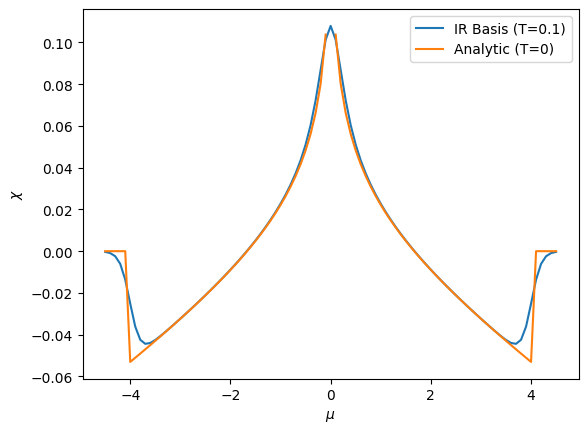

In [7]:
k = 1 - mu_range**2/16
chi_anltc = np.where(k >= 0, -(scipy.special.ellipe(k)-scipy.special.ellipk(k)/2)*(2/3)/np.pi**2, 0)

plt.plot(mu_range, chi_mu, label='IR Basis (T=0.1)')
plt.plot(mu_range, chi_anltc, label='Analytic (T=0)')
plt.xlabel("$\mu$")
plt.ylabel("$\chi$")
plt.legend()
plt.show()

In [8]:
sq3 = np.sqrt(3)
def hkgk_graphene(k):
    kx, ky = 2*np.pi*k[0]/a, 2*np.pi*(k[0] + 2*k[1])/(a*sq3)
    h = -t * (np.exp(1j*ky*a/sq3) + 2 * np.cos(kx*a/2) * np.exp(-1j*ky*a/(2*sq3)))
    hk = np.array([ [ 0, h ], [ np.conj(h), 0 ] ])
    
    hx =  t * a * np.sin(kx/2) * np.exp(-1j*ky/(2*sq3))
    hy = -t * a * (1j/sq3 * (np.exp(1j*ky/sq3) - np.cos(kx/2) * np.exp(-1j*ky/(2*sq3))))
    gx = np.array([ [ 0, hx ], [ np.conj(hx), 0 ] ])
    gy = np.array([ [ 0, hy ], [ np.conj(hy), 0 ] ])
    
    hxy = -t * a * a * 1j/(2*sq3) * np.sin(kx/2) * np.exp(-1j*ky/(2*sq3))
    gxy = np.array([ [ 0, hxy ], [ np.conj(hxy), 0 ] ])

    return hk, gx, gy, gxy

chi_mu = orbital_chi(IR_basis_set, hkgk_graphene, klist, mu_range)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57781/4135168825.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu$")
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57781/4135168825.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi$")


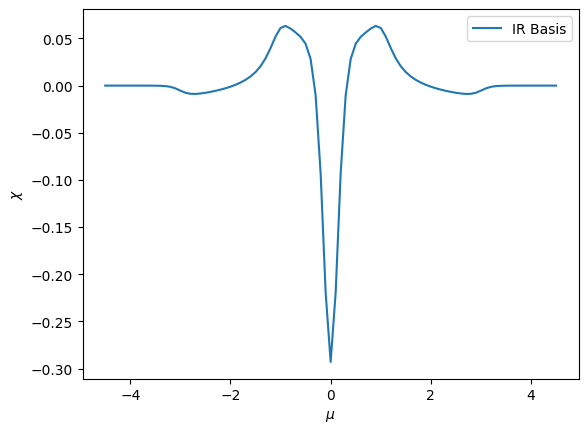

In [9]:
plt.plot(mu_range, chi_mu, label='IR Basis')
plt.xlabel("$\mu$")
plt.ylabel("$\chi$")
plt.legend()
plt.show()